In [17]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import sys
import os
import json
import torch
from torch import tensor
import yaml
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from copy import deepcopy 
from PIL import Image
import torchvision.transforms as transforms
import torch.nn.functional as F
from scipy.spatial.transform import Rotation 
from nerfstudio.cameras.camera_optimizers import CameraOptimizer
from nerfstudio.utils.eval_utils import eval_setup
from inerf.inerf_trainer import INerfTrainer
from inerf.inerf_utils import get_corrected_pose, load_eval_image_into_pipeline, get_relative_pose, get_absolute_diff_for_pose, get_image

In [19]:
os.chdir('/workspace')
MODEL_PATH = "/workspace/outputs/jackal_training_data_1/plane-nerf/2024-01-14_115715"
EVAL_PATH = "/stored_data/jackal_evaluation_data"
GROUND_TRUTH_PATH = os.path.join(EVAL_PATH, "ground_truth.json")
TRANSFORM_FILE = "transforms_10.json"
with open(GROUND_TRUTH_PATH) as f:
    GROUND_TRUTH = json.load(f)

In [20]:
config_path = os.path.join(MODEL_PATH, "config.yml")
config, pipeline, checkpoint_path, _ = eval_setup(
                        Path(config_path),
                        test_mode="inference",
                    )

WARNING: Using slower TCNN CutlassMLP instead of TCNN FullyFusedMLP

Use layer width of 16, 32, 64, or 128 to use the faster TCNN FullyFusedMLP.

WARNING: Using slower TCNN CutlassMLP instead of TCNN FullyFusedMLP

Use layer width of 16, 32, 64, or 128 to use the faster TCNN FullyFusedMLP.

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from 
outputs/jackal_training_data_1/plane-nerf/2024-01-14_115715/nerfstudio_models/step-000009999.ckpt

In [21]:
z = 2.5
pitch = 0.785
r = -2.5
init_tf = np.eye(4)
init_tf[:3, :3] = Rotation.from_rotvec(np.array([pitch, 0, 0])).as_matrix()
init_tf[0, 3] = -r
init_tf[2, 3] = z
init_tf = [init_tf]*300

In [22]:
pipeline = load_eval_image_into_pipeline(pipeline,EVAL_PATH,transform_file=TRANSFORM_FILE)
from plane_nerf.plane_nerf_optimizer import PlaneNerfCameraOptimizer

#custom_camera_optimizer = CameraOptimizer(
custom_camera_optimizer = PlaneNerfCameraOptimizer(
    config = pipeline.model.camera_optimizer.config,
    num_cameras = len(pipeline.datamanager.train_dataset),
    device = pipeline.device,
)
custom_camera_optimizer.config.rot_l2_penalty = 0 #
custom_camera_optimizer.config.trans_l2_penalty = 0 #
pipeline.model.camera_optimizer = custom_camera_optimizer
trainer = INerfTrainer(config)
trainer.setup_inerf(pipeline)

Setting up training dataset...

Caching all 300 images.

Output()

[14:01:45] Saving checkpoints to:                                                                         ]8;id=150848;file:///home/user/nerfstudio/nerfstudio/engine/trainer.py\trainer.py]8;;\:]8;id=508420;file:///home/user/nerfstudio/nerfstudio/engine/trainer.py#134\134]8;;\
           outputs/jackal_training_data_1/plane-nerf/2024-01-14_115715/nerfstudio_models                                

Loading latest Nerfstudio checkpoint from load_dir...


Done loading Nerfstudio checkpoint from 
outputs/jackal_training_data_1/plane-nerf/2024-01-14_115715/nerfstudio_models/step-000009999.ckpt

In [28]:
ground_truth_poses = []
for _ , batch in pipeline.datamanager.fixed_indices_train_dataloader:
    tf = GROUND_TRUTH["frames"][int(batch['image_idx'])]["transform_matrix"]
    tf = np.asarray(tf)
    tf = tf[:3, :4 ]
    ground_truth_poses.append(tf)
ground_truth_poses = torch.tensor(ground_truth_poses).to(pipeline.device)

In [29]:
train_loop = 10
n = 100
lr_max = 5e-3
lr_min = 1e-4
store = []

corrected_pose = get_corrected_pose(trainer)
#print(corrected_pose)
relative_pose = get_relative_pose(ground_truth_poses, corrected_pose)
t_diff, r_diff = get_absolute_diff_for_pose(relative_pose)
#Get averrage absolute translation and rotation error
print("Average translation error: ", torch.mean(t_diff))
print("Average rotation error: ", torch.mean(r_diff))

store.append([0, torch.mean(t_diff), torch.mean(r_diff)])

for i in range(train_loop):
    for j in range(n):
        lr = lr_min + (lr_max - lr_min) * (i / train_loop)
        trainer.pipeline.train()
        loss, loss_dict, metrics_dict = trainer.train_iteration_inerf(i*n + j,optimizer_lr = 1e-4)
    corrected_pose = get_corrected_pose(trainer)
    #print(corrected_pose)
    relative_pose = get_relative_pose(ground_truth_poses, corrected_pose)
    t_diff, r_diff = get_absolute_diff_for_pose(relative_pose)

    #Get averrage absolute translation and rotation error
    print("Average translation error: ", torch.mean(t_diff))
    print("Average rotation error: ", torch.mean(r_diff))
    
    store.append([n*i, torch.mean(t_diff), torch.mean(r_diff)])

Average translation error:  tensor(0.1265, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.1443, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


In [ ]:
original_img = cv2.imread(os.path.join(EVAL_PATH, GROUND_TRUTH["frames"][0]["file_path"]))
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
rendered_img = get_image(trainer.pipeline, corrected_pose[0:,:,:])
rendered_img = rendered_img["rgb"]

Text(0.5, 1.0, 'Rendered image')

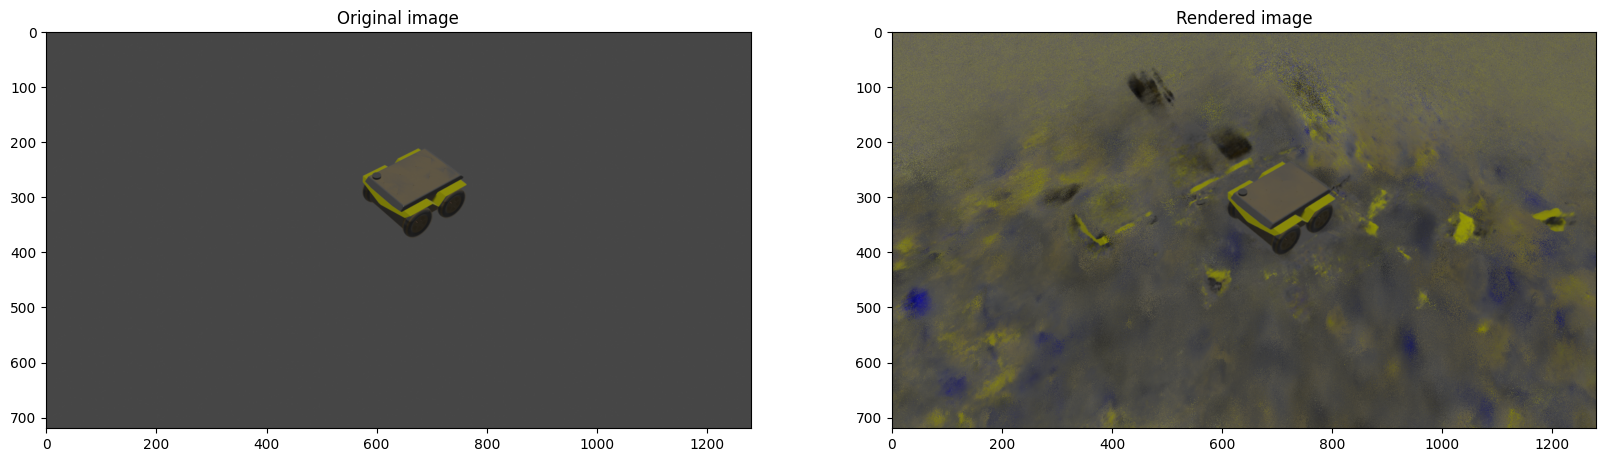

In [ ]:
#Plot original image and rendered image
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(original_img)
ax[0].set_title("Original image")
ax[1].imshow(rendered_img)
ax[1].set_title("Rendered image")

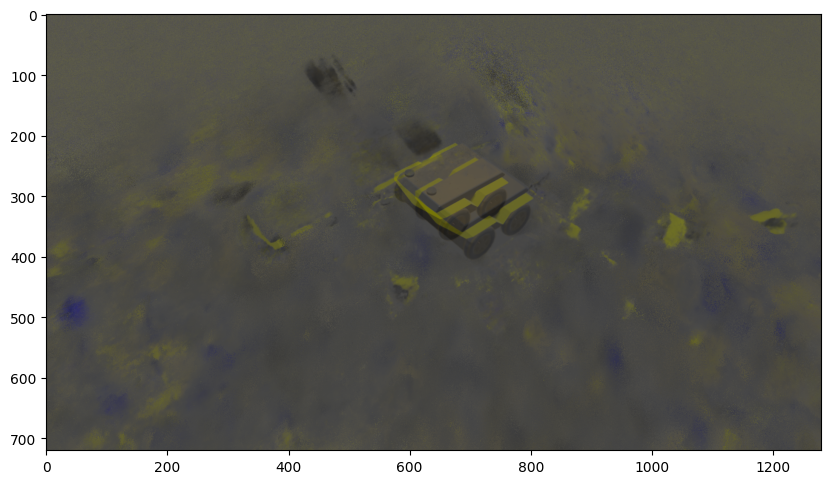

In [ ]:
#Overlay original image and rendered image
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(original_img)
ax.imshow(rendered_img, alpha=0.5)


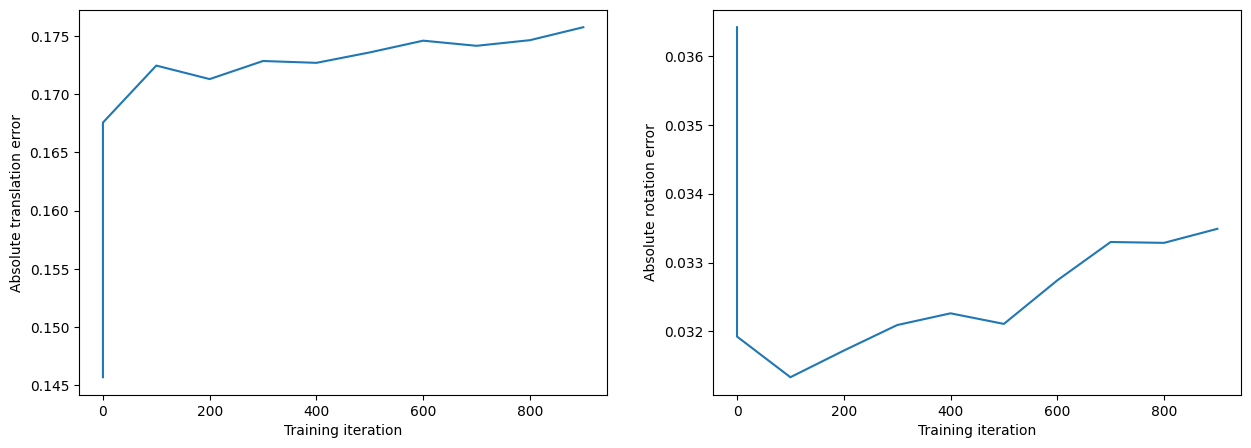

In [ ]:
#Plot store_t_diff and store_r_diff with  respect to training iteration in 2 subplots
store = np.asarray(store)
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(store[:, 0], store[:, 1])
plt.xlabel("Training iteration")
plt.ylabel("Absolute translation error")
plt.subplot(1, 2, 2)
plt.plot(store[:, 0], store[:, 2])
plt.xlabel("Training iteration")
plt.ylabel("Absolute rotation error")
plt.show()

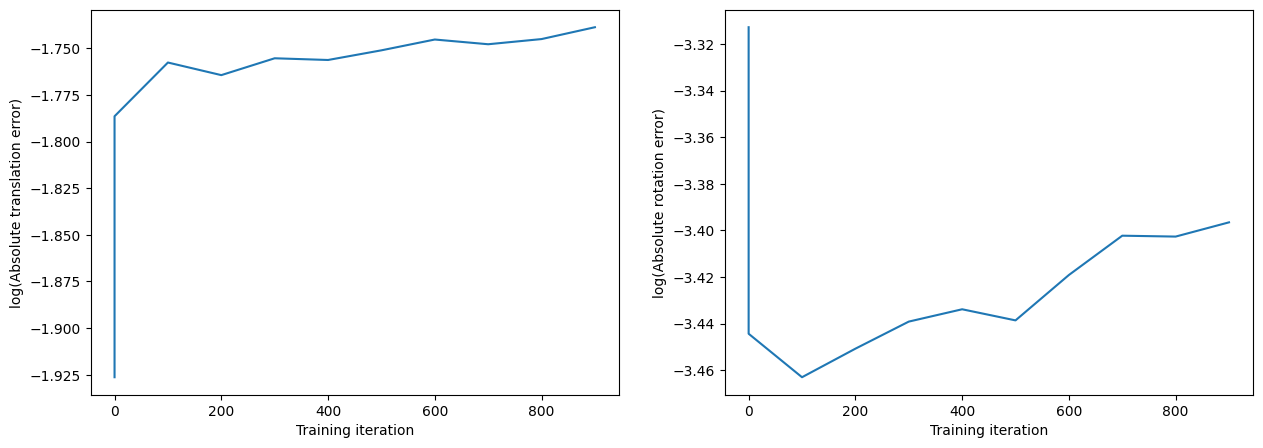

In [ ]:
#Plot store_t_diff and store_r_diff with  respect to training iteration in 2 subplots
store = np.asarray(store)
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(store[:, 0], np.log(store[:, 1]))
plt.xlabel("Training iteration")
plt.ylabel("log(Absolute translation error)")
plt.subplot(1, 2, 2)
plt.plot(store[:, 0], np.log(store[:, 2]))
plt.xlabel("Training iteration")
plt.ylabel("log(Absolute rotation error)")
plt.show()